In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random
import tensorflow as tf

# pd.set_option('display.max_columns', 100)

In [59]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [1]:
path = 'C:/Users/robin.opdam/Dropbox/'
# path = '/Users/Robin/Dropbox'
data_path = 'data/'

## Amazon Fashion

In [61]:
#Full data
# file_name = 'amazon_clothing_shoes_jewelry_data' 

# Subsets, #user ratings above 5
# file_name = 'amazon_2m'
# file_name = 'amazon_063m' 

## MovieLens

In [91]:
# Full data
# file_name = '25m_ml'

#Subsets #user ratings above 5
file_name = 'ml_2m'
# file_name = 'ml_07m'

In [92]:
df = pd.read_pickle(path + data_path + file_name)
df.head()

,user,item,rating,timestamp,verified
7511868,48786,5218,2.5,1252520796,1
1648248,11003,8961,3.5,1467192135,1
13591401,87980,7261,3.5,1117066110,1
1341601,9040,858,4.0,1007862875,1
23660300,153635,34405,5.0,1289255124,1


In [93]:
# df = df.sample(frac=0.01, random_state=1234)

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [94]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

In [95]:
df.item_id.unique().max()

29902

## Leave item out train test split

In [96]:
def leave_x_out(full_data, leave_out):
    # Input: data must contain user_id
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

In [97]:
def create_matrices(data, n_users, n_items):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

In [98]:
train_set, test_set = leave_x_out(df, 2)
val_set, test_set = leave_x_out(test_set, 1)

In [99]:
print('Leave one item out per user',
      '\n\nFull Df length:\t\t', len(df),
      '\nTraining Set length:\t', len(train_set),
      '\nTesting Set length:\t', len(test_set),
      '\nValidation Set length:\t', len(val_set))

Leave one item out per user 

Full Df length:		 1974692 
Training Set length:	 1777440 
Testing Set length:	 98626 
Validation Set length:	 98626


# Model: BPR MF in TF

- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

---
## Init: Variables

In [100]:
total_users = len(df.user_id.unique())
total_items = len(df.item_id.unique())
latent_dim = 20
learning_rate = 0.1

n_epochs = 10

user_items = train_set.groupby('user_id')['item_id'].apply(list)
train_users = train_set.user_id.unique()
train_items = train_set.item_id.unique()

In [101]:
print('Total Users:', total_users,
      '\nTotal Items:', total_items)

Total Users: 98626 
Total Items: 29903


---
## Define Model (with bias), Loss, Train Step and Helpers

In [115]:
class BPR_MF(tf.keras.Model):
    def __init__(self, init_func, total_users, total_items, latent_dim): #b_init_func
        super(BPR_MF, self).__init__()
        self.p = tf.Variable(init_func(total_users, latent_dim), name="p")
        self.q = tf.Variable(init_func(total_items, latent_dim), name="q")
#         self.b = tf.Variable(b_init_func((total_items, 1)), name="b")
    
    def call(self, uij):
        return tf.math.multiply(self.p[uij[0]], (self.q[uij[1]] - self.q[uij[2]]))

In [116]:
class Loss:
    def __call__(self, x):
        return - tf.math.log_sigmoid(tf.math.reduce_sum(x))

In [117]:
@tf.function
def train_step(model, optimizer, uij):
    with tf.GradientTape(persistent=True) as tape:
        x = model(uij) 
        loss = loss_obj(x) # -x or not? 

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [118]:
def draw_sample(train_users, train_items, user_items):
    u = int(np.random.choice(train_users))
    u_items = user_items[u]
    i = random.choice(u_items)
    j = int(np.random.choice(train_items)) # neg item

    while j in u_items: # j cannot be the same item or an item with a 1
        j = int(np.random.choice(train_items))
        
    return [u, i, j]

---
# Train Model

## Init Model and Loss

In [119]:
normal_init = lambda v, d: tf.random.normal((v, d), 0.0, 1.0/d)
zero_init = lambda v: tf.zeros(v,1)

model = BPR_MF(normal_init, total_users, total_items, latent_dim)

In [120]:
loss_obj = Loss()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

---
## Train Loop

In [ ]:
train_time_s = time.time()
total_losses = []
for epoch in tf.range(n_epochs):
    ep_time_s = time.time()
    ep_losses = []
    for sample in tf.range(len(train_set)):
        uij_sample = draw_sample(train_users, train_items, user_items)
        loss = train_step(model, optimizer, uij_sample)
        
        ep_losses.append(loss)
    ep_loss = np.average(ep_losses)
    
    print('Epoch:', epoch.numpy(), '\tLoss:', round(ep_loss,4), '\tEpoch Time:', time.time() - ep_time_s)
    total_losses.append(ep_loss)

print('Total training time:', time.time() - train_time_s)

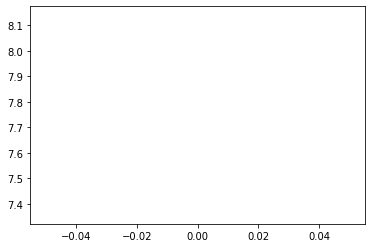

In [79]:
plt.plot(total_losses)
plt.show()

---
## Quick np save/load

In [80]:
# np.savetxt('Results/BPR_TF/p.txt', model.p.numpy(), fmt='%f')
# np.savetxt('Results/BPR_TF/q.txt', model.q.numpy(), fmt='%f')


p = np.loadtxt(path + 'Results/BPR_TF/p.txt', dtype=float)
q = np.loadtxt(path + 'Results/BPR_TF/q.txt', dtype=float)

# Evaluate Model

---
## Rank items per user

In [81]:
import eval_rank_bpr
result = {'p':p, 'q':q}
users = test_set.user_id.unique()
items = test_set.item_id.unique()
test_user_items = test_set.groupby('user_id')['item_id'].apply(list)

s = time.time()
rank_at = 20
mp_splits = 4
users_split = np.array_split(users, mp_splits)
        
if __name__ == '__main__':
    pool = mp.Pool(processes = mp_splits)
    ranked = pool.map(eval_rank_bpr.eval_rank_bpr, [[result, users_split[0], items, test_user_items, rank_at], 
                                            [result, users_split[1], items, test_user_items, rank_at], 
                                            [result, users_split[2], items, test_user_items, rank_at], 
                                            [result, users_split[3], items, test_user_items, rank_at]])
    pool.close()
    
    ranked_df = pd.DataFrame()

    for i in range(mp_splits):
        ranked_df = pd.concat([ranked_df, ranked[i]])
        
    t = time.time() - s
    print(t/60)

122.44964896440506


In [82]:
steps = 5
ranks_at = [1] + [i for i in range(steps, rank_at + steps, steps)]
ranks_at

[1, 5, 10, 15, 20]

In [83]:
ranked_df.head()

,scores_ranked,pred_items_ranked,true_id
0,"(2.1050361468449994, 1.9752039243769999, 1.911...","(236, 307, 8369, 308, 5209, 8098, 237, 6093, 5...",[71625]
1,"(6.9926446383470005, 6.970577475948, 6.8507708...","(81722, 81204, 80191, 77887, 80148, 77888, 828...",[80191]
2,"(3.28214720109, 2.9024799137599997, 2.70580579...","(83556, 81722, 52021, 80191, 3503, 81204, 1762...",[44008]
3,"(1.090095418711, 1.056605869492, 1.02079935229...","(23723, 71463, 6486, 35207, 3315, 4483, 18436,...",[87126]
4,"(4.718846760408, 3.695005577129, 3.58466118151...","(83556, 95746, 84213, 4444, 1760, 52021, 3505,...",[11497]


---
## Calc Hits@, Rec@ and Prec@

In [84]:
hitcounts = []
recs_at = []
precs_at = []
bpr_tf = pd.DataFrame(columns=['rank_at', 'hitcounts', 'recall', 'precision'])
for rank in ranks_at:
    hitcount = 0
    for u in ranked_df.index:
        hitcount +=  len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked'][:rank]))
                    
    prec_at = hitcount / rank / len(ranked_df)
    rec_at = hitcount / len(ranked_df.iloc[0]['true_id']) / len(ranked_df)
    
    print('rank_at:', rank, '  Hits:', hitcount)
    hitcounts.append(hitcount)                     
    recs_at.append(rec_at)
    precs_at.append(prec_at)

bpr_tf['rank_at'] = ranks_at
bpr_tf['hitcounts'] = hitcounts
bpr_tf['recall'] = recs_at
bpr_tf['precision'] = precs_at
bpr_tf

rank_at: 1   Hits: 925
rank_at: 5   Hits: 4149
rank_at: 10   Hits: 7518
rank_at: 15   Hits: 9605
rank_at: 20   Hits: 11202


,rank_at,hitcounts,recall,precision
0,1,925,0.010141,0.010141
1,5,4149,0.045485,0.009097
2,10,7518,0.082420,0.008242
3,15,9605,0.105300,0.007020
4,20,11202,0.122807,0.006140


---
## Store Results

In [85]:
result_path = 'Results/BPR_TF/'
bpr_tf.to_pickle(path + result_path + file_name + '_bpr_tf_res')

In [86]:
bpr_tf

,rank_at,hitcounts,recall,precision
0,1,925,0.010141,0.010141
1,5,4149,0.045485,0.009097
2,10,7518,0.082420,0.008242
3,15,9605,0.105300,0.007020
4,20,11202,0.122807,0.006140


In [90]:
pd.read_pickle(path + result_path + 'ml_07m' + '_bpr_tf_res')

,rank_at,hitcounts,recall,precision
0,1,117,0.002156,0.002156
1,5,495,0.009120,0.001824
2,10,912,0.016803,0.001680
3,15,1343,0.024743,0.001650
4,20,1736,0.031984,0.001599
